In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

In [5]:
flow = np.zeros((448, 832, 2))
#gt = mpimg.imread('../example_data/data/DAVIS/Annotations/480p/train/00023.png')[16:-16,11:-11]
gt = np.zeros((448, 832))

In [6]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [7]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [8]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

In [9]:
def mse_loss(f1, f2):
    return tf.reduce_sum(tf.square(f1 - f2), axis=-1, keep_dims=True)

In [10]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

In [11]:
w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

In [12]:
normalizer = tf.zeros((1, 448, 832, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:832,0],
                           tf.zeros((1, 448, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 832), dtype=tf.float32),
                           gt_mask[:,0:(448-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 448, j), dtype=tf.float32),
                           gt_mask[:,:,0:(832-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:448,:,3],
                           tf.zeros((1, j, 832), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(448), Dimension(832), Dimension(2)])

In [13]:
def fixed_point_update(flow, gamma, itr):
    flow_copy1 = flow * 1.0
    flow_copy2 = flow * 1.0
    flow_copy1 = tf.stop_gradient(flow_copy1)
    flow_copy2 = tf.stop_gradient(flow_copy2)

    for k in range(itr):
        temp = tf.zeros_like(flow)
        for i in range(w):
            j = i + 1
            temp += tf.concat([flow_copy1[:,:,j:832,:],
                               tf.zeros((1, 448, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

            temp += tf.concat([tf.zeros((1, j, 832, 2), dtype=tf.float32),
                               flow_copy1[:,0:(448-j),:,:]], axis=1) * multiplier_masks[i][1]

            temp += tf.concat([tf.zeros((1, 448, j, 2), dtype=tf.float32),
                               flow_copy1[:,:,0:(832-j),:]], axis=2) * multiplier_masks[i][2]

            temp += tf.concat([flow_copy1[:,j:448,:,:],
                               tf.zeros((1, j, 832, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

        temp += gamma * flow_copy2
        flow_copy1 = temp / (normalizer + gamma)
    return flow_copy1

In [14]:
gammaTensor = tf.placeholder(tf.float32,shape=[])
golTensor = tf.placeholder(tf.float32,shape=[])
inner_itr = 10

def adm_loss_fn(flow, gol, gamma):
    pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)
    actual_smooth_loss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    actual_smooth_loss = tf.stop_gradient(actual_smooth_loss)
    fhat = fixed_point_update(flow, gol, inner_itr)
    sLoss = asymmetricSmoothLoss(fhat, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    mLoss = mse_loss(flow, fhat)

    return pLoss, sLoss, gamma * mLoss, actual_smooth_loss, fhat

In [15]:
photo_loss, smooth_loss, eucl_loss, as_loss, fhat = adm_loss_fn(flow, golTensor, gammaTensor)
adm_loss = photo_loss + smooth_loss + eucl_loss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
sGrad = tf.gradients(smooth_loss, fhat)
pGrad = tf.gradients(photo_loss, flow)
mGrad = tf.gradients(eucl_loss, flow)
tGrad = tf.gradients(adm_loss, flow)

In [17]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [18]:
solver, solver_op, learningRateTensor = attach_ADAM_Solver(adm_loss)

In [19]:
itr = 1000

In [22]:
init = tf.global_variables_initializer()
mLosses, sLosses, pLosses, asLosses = [], [], [], []
tGrads, sGrads, pGrads, mGrads = [], [], [], []
flows, flow_props = [], []

print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            gammaTensor: 80000,
            golTensor: 8
        }
        _, s, p, m, f, fp, asl, pg, mg = sess.run([solver_op,
                                      smooth_loss,
                                      photo_loss,
                                      eucl_loss,
                                      flow,
                                      fhat,
                                      as_loss,
                                      pGrad,
                                      mGrad], feed_dict = feed_dict)

        if i % print_freq == 1:
            print(i)
            flows.append(deepcopy(f[0]))
            flow_props.append(deepcopy(fp[0]))
            sLosses.append(np.mean(s))
            asLosses.append(np.mean(asl))
            pLosses.append(np.mean(p))
            mLosses.append(np.mean(m))
            pGrads.append(np.median(np.abs(pg[0])))
            mGrads.append(np.median(np.abs(mg[0])))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss after fixed point update: %f" % sLosses[-1]
            print "Smooth loss after fixed point update without border: %f" % np.mean(s[:,1:-1,1:-1,:])
            print "Smooth loss from \"network\": %f" % np.mean(asl)
            print "Smooth loss from \"network\" without border: %f" % np.mean(asl[:,1:-1,1:-1,:])

1
Photo loss: 2944.343994
Smooth loss after fixed point update: 0.000004
Smooth loss after fixed point update without border: 0.000004
Smooth loss from "network": 0.000004
Smooth loss from "network" without border: 0.000004
11
Photo loss: 1397.104858
Smooth loss after fixed point update: 0.664783
Smooth loss after fixed point update without border: 0.663093
Smooth loss from "network": 1.489626
Smooth loss from "network" without border: 1.489184
21
Photo loss: 1362.371948
Smooth loss after fixed point update: 0.156004
Smooth loss after fixed point update without border: 0.153028
Smooth loss from "network": 0.319292
Smooth loss from "network" without border: 0.316466
31
Photo loss: 1186.699097
Smooth loss after fixed point update: 0.062732
Smooth loss after fixed point update without border: 0.057814
Smooth loss from "network": 0.101874
Smooth loss from "network" without border: 0.096888
41
Photo loss: 1034.128418
Smooth loss after fixed point update: 0.051473
Smooth loss after fixed poi

381
Photo loss: 220.271439
Smooth loss after fixed point update: 0.045376
Smooth loss after fixed point update without border: 0.013437
Smooth loss from "network": 0.048073
Smooth loss from "network" without border: 0.016030
391
Photo loss: 219.144119
Smooth loss after fixed point update: 0.045349
Smooth loss after fixed point update without border: 0.013399
Smooth loss from "network": 0.048037
Smooth loss from "network" without border: 0.015982
401
Photo loss: 218.212891
Smooth loss after fixed point update: 0.045371
Smooth loss after fixed point update without border: 0.013420
Smooth loss from "network": 0.048139
Smooth loss from "network" without border: 0.016085
411
Photo loss: 217.364166
Smooth loss after fixed point update: 0.045388
Smooth loss after fixed point update without border: 0.013432
Smooth loss from "network": 0.048171
Smooth loss from "network" without border: 0.016113
421
Photo loss: 216.849594
Smooth loss after fixed point update: 0.045435
Smooth loss after fixed po

761
Photo loss: 199.703751
Smooth loss after fixed point update: 0.045823
Smooth loss after fixed point update without border: 0.013844
Smooth loss from "network": 0.050272
Smooth loss from "network" without border: 0.018195
771
Photo loss: 199.538864
Smooth loss after fixed point update: 0.045805
Smooth loss after fixed point update without border: 0.013830
Smooth loss from "network": 0.050251
Smooth loss from "network" without border: 0.018174
781
Photo loss: 198.961243
Smooth loss after fixed point update: 0.045853
Smooth loss after fixed point update without border: 0.013878
Smooth loss from "network": 0.050443
Smooth loss from "network" without border: 0.018364
791
Photo loss: 198.082184
Smooth loss after fixed point update: 0.045797
Smooth loss after fixed point update without border: 0.013823
Smooth loss from "network": 0.050386
Smooth loss from "network" without border: 0.018315
801
Photo loss: 198.012787
Smooth loss after fixed point update: 0.045798
Smooth loss after fixed po

max flow: 8.7038
flow range:
u = -3.556 .. 7.920
v = -6.340 .. 2.123


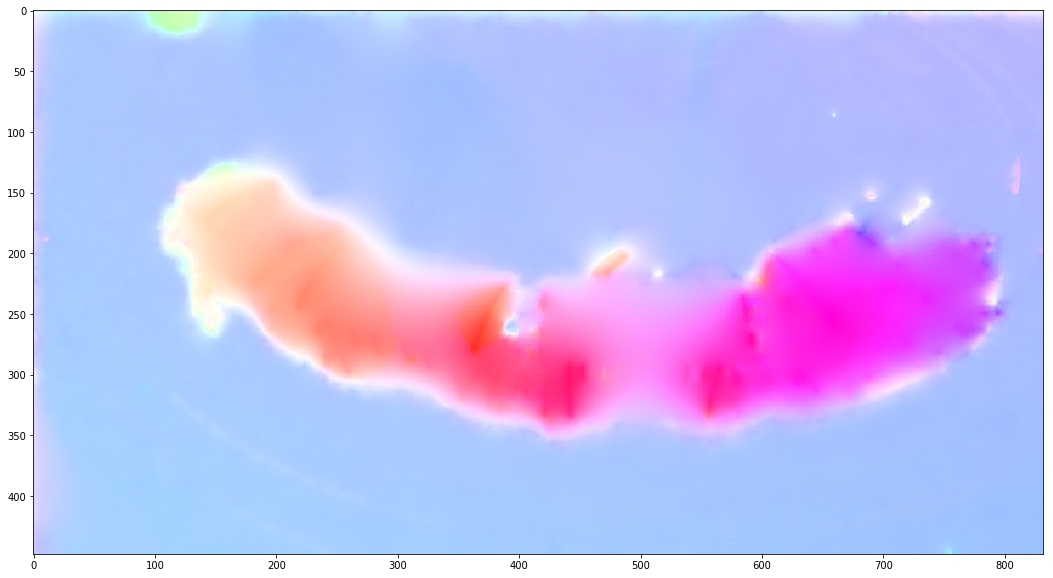

In [21]:
plt.figure(figsize=(20, 10))
plt.imshow(flow_to_image(flows[-1]))

In [23]:
f = tf.cast(np.expand_dims(flows[-1], 0), tf.float32)
f.shape
asl = asymmetricSmoothLoss(f, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
res = asl.eval(session=tf.Session())

TensorShape([Dimension(1), Dimension(448), Dimension(832), Dimension(2)])

In [29]:
np.mean(res[:,1:-1,1:-1,:])

0.013402575

In [57]:
mLosses = np.array(mLosses)
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
asLosses = np.array(asLosses)
tLosses = pLosses + mLosses

total_loss = pLosses + 1000 * asLosses

max flow: 15.4366
flow range:
u = -9.190 .. 9.235
v = -13.886 .. 10.753


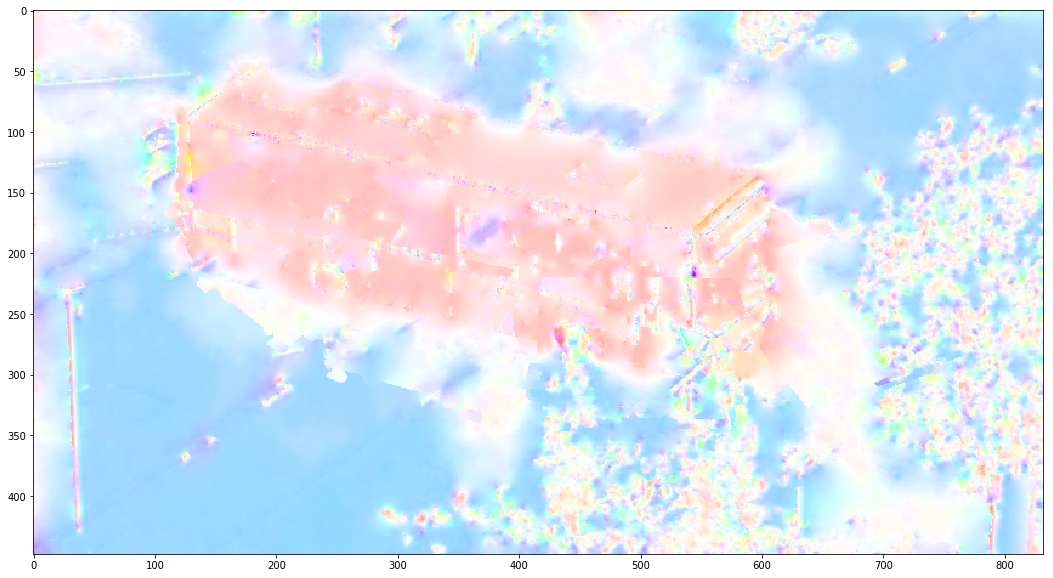

In [58]:
plt.figure(figsize=(20, 10))
plt.imshow(flow_to_image(flows[80]))

In [39]:
im = Image.fromarray(flow_to_image(flows[80]))

max flow: 6.6458
flow range:
u = -6.621 .. 4.951
v = -3.994 .. 3.805


In [40]:
im.save("bus_adm_noseg.png")

In [20]:
# np.save("split_train_ADAM_lambda10k", total_loss)
# np.save("split_train_ADAM_lambda1k", total_loss)
# np.save("split_train_sgd_lambda_10k", total_loss)
np.save("split_train_sgd_lambda1k", total_loss)